In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import Tensor
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import transformers

import quantisation as Q

transformers.logging.disable_progress_bar()
matplotlib.rcParams.update({"axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False})

def snr(t: Tensor, q: Tensor) -> Tensor:
    return t.pow(2).sum() / (t - q).pow(2).sum()

In [3]:
if "model" in globals():
    del model
model = transformers.AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")
tokenizer = transformers.AutoTokenizer.from_pretrained(model.config._name_or_path)

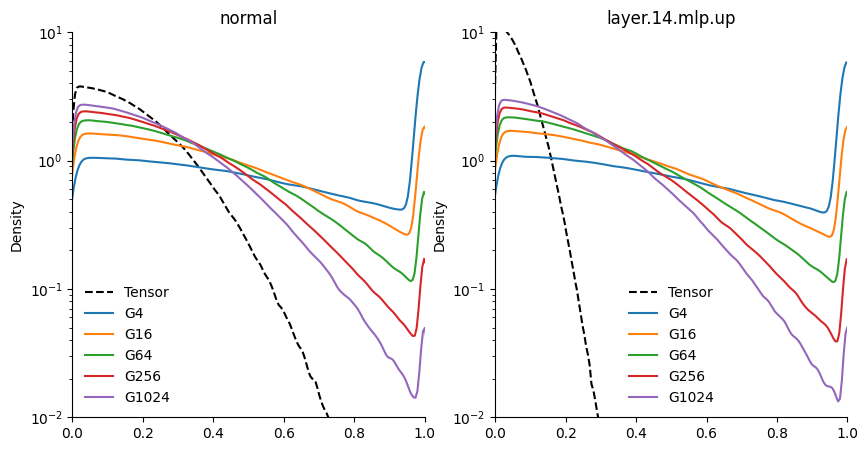

In [15]:
t0 = torch.randn(2**20).abs()
t1 = model.model.layers[14].mlp.up_proj.weight.detach()[:1024, :1024].abs()
_, axs = plt.subplots(ncols=2, figsize=(10, 5))
for ax, t, title in zip(axs, [t0, t1], ["normal", "layer.14.mlp.up"]):
    sns.kdeplot(t.flatten() / t.max(), color="k", ls="--", bw_method=0.05, label="Tensor", ax=ax)
    for g in [4, 16, 64, 256, 1024]:
        sns.kdeplot(t.reshape(-1, g).div(t.reshape(-1, g).max(dim=1, keepdim=True).values).flatten(), label=f"G{g}", ax=ax, bw_method=0.05)
    ax.set_yscale("log")
    ax.set_xlim((0, 1))
    ax.set_ylim((10**-2, 10**1))
    ax.legend()
    ax.set_title(title)

In [21]:
t = torch.randn((4096, 4096))
df = pd.DataFrame.from_records([
    dict(g=g, fmt=efmt, ebits=fmt.element_format.bits, etype=fmt.element_format._type,
         snr=snr(t, fmt.quantise(t)).item(), bpp=fmt.count_bits(t.shape)/t.nelement())
    for g in [8, 16, 32, 64, 128, 256, 512, 1024]
    for efmt in ["E0M2", "E0M3", "E2M1", "E0M4", "E2M2"]
    for fmt in [Q.group_scaling_format(Q.parse(efmt), "input", g,
                                    #    scale_format=Q.BFLOAT16,
                                    #    scale_format=Q.parse("E7M0-RI"),
                                       scale_format=Q.parse("E2M5"),
                                       )]
])

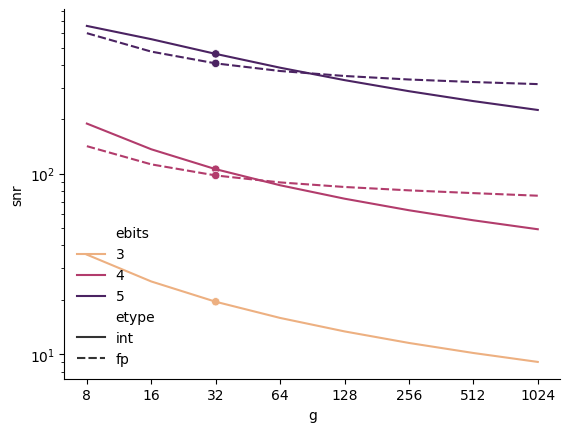

In [22]:
ax = sns.lineplot(data=df, y="snr", x="g", hue="ebits", style="etype", hue_norm=matplotlib.colors.LogNorm(), palette="flare")
sns.scatterplot(data=df[df.g==32], y="snr", x="g", hue="ebits", hue_norm=matplotlib.colors.LogNorm(), palette="flare", ax=ax, legend=False)
ax.set_xscale("log", base=2)
ax.set_yscale("log")
ax.xaxis.set_major_formatter("{x:.0f}")

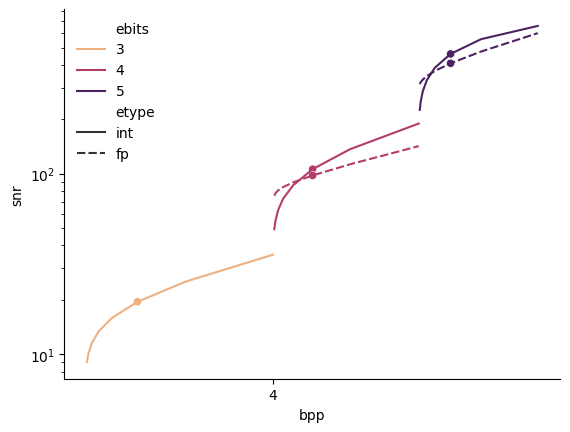

In [12]:
ax = sns.lineplot(data=df, y="snr", x="bpp", hue="ebits", style="etype", hue_norm=matplotlib.colors.LogNorm(), palette="flare")
sns.scatterplot(data=df[df.g==32], y="snr", x="bpp", hue="ebits", hue_norm=matplotlib.colors.LogNorm(), palette="flare", ax=ax, legend=False)
ax.set_xscale("log", base=2)
ax.set_yscale("log")
ax.xaxis.set_major_formatter("{x:.0f}")

In [ ]:
t = torch.randn((3072, 3072))
t = model.model.layers[14].mlp.up_proj.weight.detach()
g = 16
print(snr(t, Q.group_scaling_format(Q.parse("E0M2"), "input", g).quantise(t)))
print(snr(t, Q.group_scaling_format(Q.parse("E0M3"), "input", g).quantise(t)))
print(snr(t, Q.group_scaling_format(Q.parse("E2M1"), "input", g).quantise(t)))
print(snr(t, Q.group_scaling_format(Q.parse("E3M0"), "input", g).quantise(t)))

tensor(24.4945)
tensor(133.5097)
tensor(113.5689)
tensor(35.8801)


In [106]:
fmt = Q.LinearScalingFormat(Q.parse("E0M3"), [(1, 32)], scale_format=Q.BFLOAT16, scale_combiner=None)
print(fmt.count_bits(t.shape) / t.nelement(), snr(t, fmt.quantise(t)))

4.5 tensor(101.9314)


In [107]:
fmt = Q.LinearScalingFormat(Q.parse("E0M3"), [(1, 64), (64, 1)], scale_format=Q.BFLOAT16, scale_combiner="min")
print(fmt.count_bits(t.shape) / t.nelement(), snr(t, fmt.quantise(t)))

4.5 tensor(104.0836)


(1e-06, 1000)

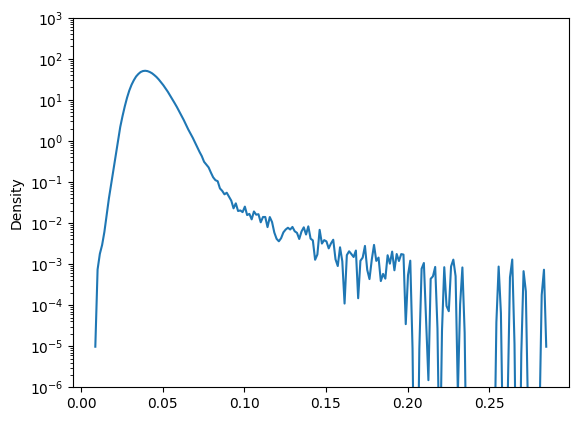

In [83]:
t = model.model.layers[0].mlp.up_proj.weight.detach()
g = 32
# ax = sns.kdeplot(t.reshape(-1, g).abs().sort(1).values[:, -2] / t.reshape(-1, g).abs().sort(1).values[:, -1])
ax = sns.kdeplot(t.reshape(-1, g).abs().sort(1).values[:, -1])
ax.set_yscale("log")
ax.set_ylim((10**-6, 10**3))

(1e-06, 1000)

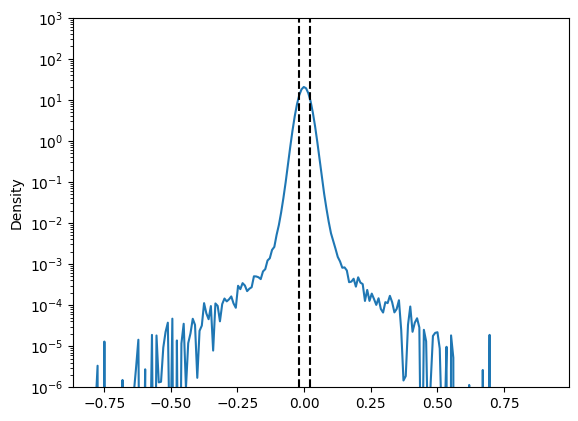

In [60]:
t = model.model.layers[-1].mlp.up_proj.weight.detach()
ax = sns.kdeplot(t.flatten())
ax.set_yscale("log")
ax.axvline(-t.std(), color="k", ls="--")
ax.axvline(t.std(), color="k", ls="--")
ax.set_ylim((10**-6, 10**3))
# plt.imshow(t[:1024, :1024], cmap="grey")

In [ ]:
# {k: tuple(v.shape) for k, v in dict(model.named_parameters()).items()}